In [1]:
%load_ext autoreload

In [63]:
%autoreload

import matplotlib.pyplot as plt
import pandas as pd

from pyinla.model import *
from pyinla.utils import *

In [ ]:
# load dataset
ds = ro.r("data(Drivers); Drivers")[:192]

In [32]:
formula = """
sqrt(y) ~ 1 + belt +
          f(trend, 
            model="rw2", 
            param=c(1, 0.0005), 
            initial=-3) + 
          f(seasonal,
            model="seasonal", 
            season.length=12, 
            param=c(1, 0.1), 
            initial=2)
            """

In [58]:
result = inla(
    formula,
    data=ds,
    family="gaussian",
    control_inla=dict(h=0.01),
    control_predictor=dict(compute=True, link=1),
    control_compute=dict(config=True, return_marginals_predictor=True),
).improve_hyperpar()

In [34]:
result

Time used:
     = 0.937,  = 0.745,  = 0.0853,  = 1.77 
Fixed effects:
              mean    sd 0.025quant 0.5quant 0.975quant   mode kld
(Intercept) 41.414 0.170     41.081   41.414     41.748 41.413   0
belt        -5.790 1.409     -8.560   -5.788     -3.029 -5.785   0

Random effects:
  Name	  Model
    trend RW2 model
   seasonal Seasonal model

Model hyperparameters:
                                           mean     sd 0.025quant 0.5quant
Precision for the Gaussian observations 560.604 243.17    186.245  530.268
Precision for trend                       5.162   1.62      2.699    4.920
Precision for seasonal                    0.907   0.14      0.658    0.899
                                        0.975quant    mode
Precision for the Gaussian observations    1114.27 447.845
Precision for trend                           9.03   4.470
Precision for seasonal                        1.21   0.884

Marginal log-Likelihood:  -433.22 
 is computed 
Posterior summaries for the linear predi

In [36]:
fitted = result.get_marginal_type("fitted.values")
modes = np.stack(fitted.apply(lambda x: x.mode()))
stds = np.stack(fitted.apply(lambda x: x.quantile([0.025, 0.975])))

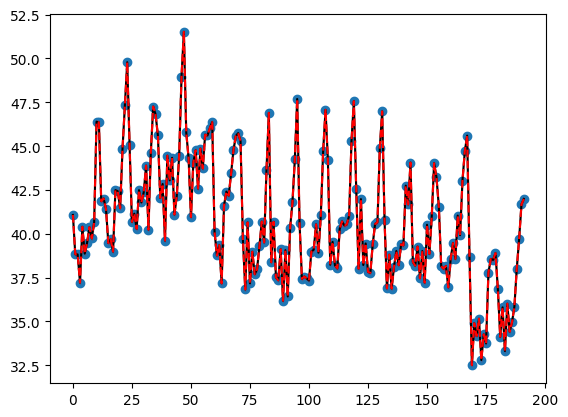

In [53]:
# posterior predictive check
xr = np.arange(len(ds))
plt.scatter(xr, np.sqrt(ds["y"].values))
plt.plot(xr, np.sqrt(ds["y"].values), c="k")
plt.plot(xr, modes, c="r", ls="--")
plt.fill_between(xr, stds[:, 0], stds[:, 1], alpha=0.2, color="r")

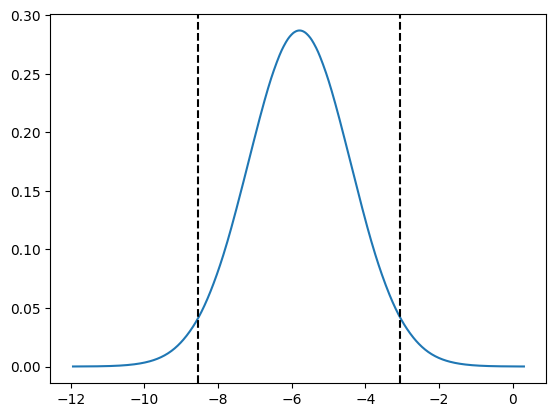

In [65]:
# check the significance of belt. it is well below 0
belt = result.get_marginal_type("fixed").get_marginal("belt")
belt.spline().plot()
for i in belt.ci(0.95):
    plt.axvline(i, c="k", ls="--")